# Decision Weaving NK Simulation

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import itertools
from time import time
import os
import sys
import scipy.stats as st
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

## Parameters

In [5]:
RUNS = 10
P = 4
D = 3
i = 100
FILENAME = "NK_landscape_" + "P_" + str(P) + "_D_" + str(D)
# Filename format: NK_landscape_P_4_D_3_K_within_0.0_K_between_0.0_i_100.npy

In [6]:
FILENAME

'NK_landscape_P_4_D_3'

## Experiment 1 - Complexity

In [7]:
K_w = [0.0, 0.25, 0.5, 0.75, 1.0]
K_b = [0.0, 0.25, 0.5, 0.75, 1.0]
threshold = 1

In [11]:
DW_FIT = []
DW_CI = []

LOCAL_FIT = []
LOCAL_CI = []

for kw in K_w:
    for kb in K_b:
        filename = FILENAME + "_K_within_" + str(kw) + "_K_between_" + str(kb) + "_i_" + str(i) + ".npy"
        NK = np.load(filename)
        Domain_decision_set = domain_dec_set(D)
        i = NK.shape[0]
        N = int(np.log2(NK.shape[1]))
        Power_key = powerkey(N)

        num_local_steps = []
        num_local_scans = []
        final_local_fitness = []

        num_dw_steps = []
        num_dw_scans = []
        final_dw_fitness = []

        for land in range(i): 
            for _ in range(RUNS):
                start = random_start(N)

                (local_steps, local_scans, local_fit) = local_search(start, N, NK[land], Power_key)
                (dw_steps, dw_scans, dw_fit) = decision_weaving(start, N, P, D, NK[land], Power_key, Domain_decision_set)

                num_local_steps.append(local_steps)
                num_local_scans.append(local_scans)
                final_local_fitness.append(local_fit)

                num_dw_steps.append(dw_steps)
                num_dw_scans.append(dw_scans)
                final_dw_fitness.append(dw_fit)

        DW_FIT.append(np.mean(final_dw_fitness))
        LOCAL_FIT.append(np.mean(final_local_fitness))
        
        DW_CI.append(conf_int_hw(final_dw_fitness))
        LOCAL_CI.append(conf_int_hw(final_local_fitness))

In [12]:
len(DW_FIT)

25

In [13]:
DW = np.reshape(DW_FIT, (5, 5)).T

In [17]:
DW

array([[ 0.65541404,  0.6972757 ,  0.70315235,  0.7281455 ,  0.73821941],
       [ 0.68649395,  0.7019936 ,  0.71561241,  0.70663403,  0.71518393],
       [ 0.70382316,  0.6993023 ,  0.70572009,  0.70004188,  0.70019063],
       [ 0.69764175,  0.69620028,  0.69142662,  0.68711684,  0.68474247],
       [ 0.68425619,  0.68244701,  0.67903008,  0.67771134,  0.6730585 ]])

In [14]:
L = np.reshape(LOCAL_FIT, (5, 5)).T

In [18]:
L

array([[ 0.65541404,  0.68227418,  0.6786558 ,  0.68469431,  0.69127181],
       [ 0.68213893,  0.69787226,  0.70609378,  0.69374186,  0.7008374 ],
       [ 0.70159031,  0.68923089,  0.69929286,  0.68927175,  0.68464623],
       [ 0.68769638,  0.68516422,  0.67753537,  0.66989485,  0.66605184],
       [ 0.66943274,  0.6651211 ,  0.65740442,  0.65912847,  0.65284141]])

In [20]:
np.argmax(L)

7

In [15]:
X, Y = np.meshgrid(K_w, K_b)

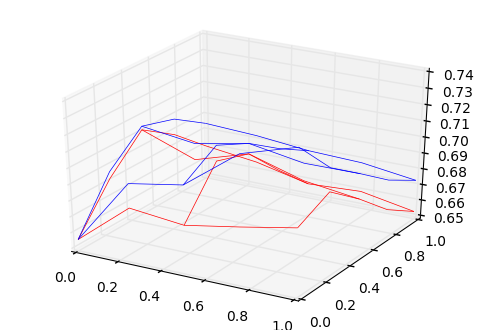

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, DW, rstride=2, cstride=2, linewidth=0.5, color="b")
ax.plot_wireframe(X, Y, L, rstride=2, cstride=2, linewidth=0.5, color="r")
#ax.xlabel("K-within")
#ax.ylabel("K-between")
#ax.zlabel("Performance")
#ax.title("Decision Weaving vs. Local Search")

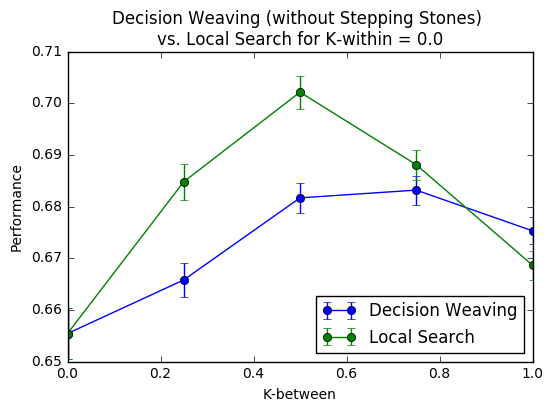

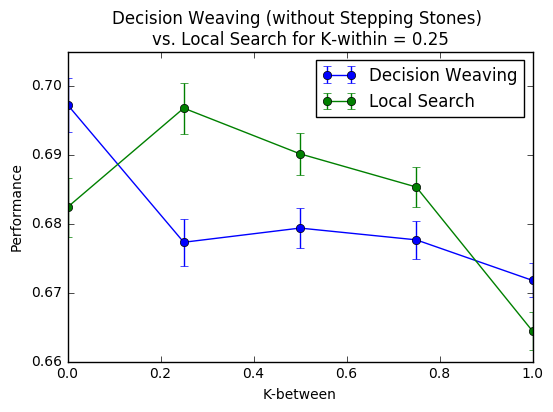

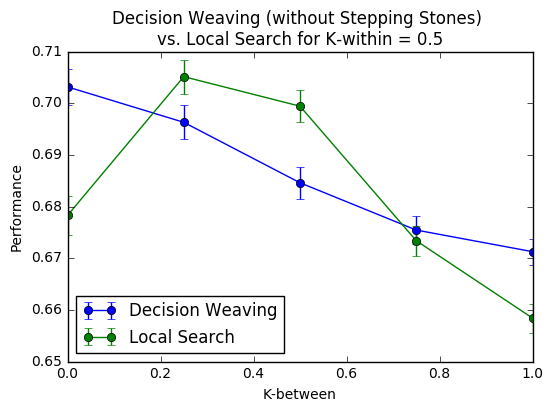

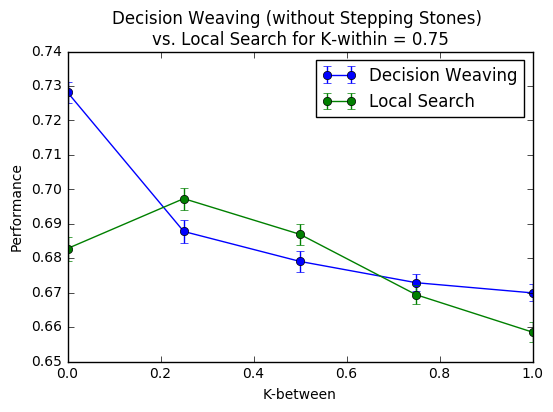

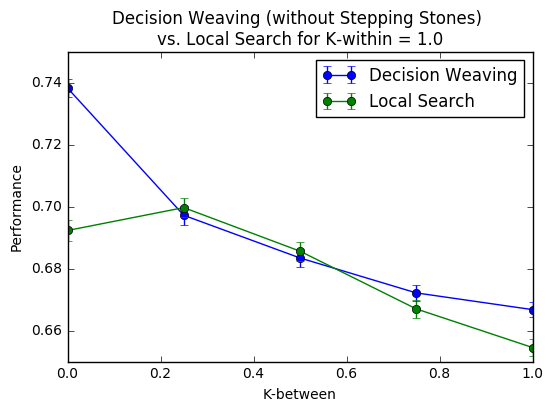

In [16]:
for kw in range(len(K_w)):
    title_str = "Decision Weaving (without Stepping Stones) \nvs. Local Search for K-within = " + str(K_w[kw])

    plt.figure()
    plt.errorbar(K_b, DW_FIT[kw*len(K_b):(kw+1)*len(K_b)], yerr=DW_CI[kw*len(K_b):(kw+1)*len(K_b)], fmt='-o', label='Decision Weaving')
    plt.errorbar(K_b, LOCAL_FIT[kw*len(K_b):(kw+1)*len(K_b)], yerr=LOCAL_CI[kw*len(K_b):(kw+1)*len(K_b)], fmt='-o', label='Local Search')
    plt.xlabel("K-between")
    plt.ylabel("Performance")
    plt.title(title_str)
    plt.legend(loc='best')

In [43]:
'''plt.figure()
plt.errorbar(K_b, DW_FIT[:len(K_b)], yerr=DW_CI[:len(K_b)], fmt='-o', label='Decision Weaving')
plt.errorbar(K_b, LOCAL_FIT[:len(K_b)], yerr=LOCAL_CI[:len(K_b)], fmt='-o', label='Local Search')
plt.xlabel("K-between")
plt.ylabel("Performance")
plt.title("Decision weaving vs. Local Search for K-within = 0")
plt.legend(loc='best')'''

'plt.figure()\nplt.errorbar(K_b, DW_FIT[:len(K_b)], yerr=DW_CI[:len(K_b)], fmt=\'-o\', label=\'Decision Weaving\')\nplt.errorbar(K_b, LOCAL_FIT[:len(K_b)], yerr=LOCAL_CI[:len(K_b)], fmt=\'-o\', label=\'Local Search\')\nplt.xlabel("K-between")\nplt.ylabel("Performance")\nplt.title("Decision weaving vs. Local Search for K-within = 0")\nplt.legend(loc=\'best\')'

## Experiment 2 - Learning Threshold

In [82]:
filename = "NK_landscape_P_4_D_3_K_within_0.5_K_between_0.5_i_100.npy"
learning_thresholds = [0, 1, 2, 3, 4, 5, 6]

In [83]:
thresh_DW_FIT = []
thresh_DW_CI = []
thresh_LOCAL_FIT = []
thresh_LOCAL_CI = []

for threshold in learning_thresholds:
    NK = np.load(filename)
    Domain_decision_set = domain_dec_set(D)
    i = NK.shape[0]
    N = int(np.log2(NK.shape[1]))
    Power_key = powerkey(N)

    num_local_steps = []
    num_local_scans = []
    final_local_fitness = []

    num_dw_steps = []
    num_dw_scans = []
    final_dw_fitness = []

    for land in range(i): 
        for _ in range(RUNS):
            start = random_start(N)

            (local_steps, local_scans, local_fit) = local_search(start, N, NK[land], Power_key)
            (dw_steps, dw_scans, dw_fit) = decision_weaving_threshold(start, N, P, D, NK[land], Power_key, Domain_decision_set, threshold)

            num_local_steps.append(local_steps)
            num_local_scans.append(local_scans)
            final_local_fitness.append(local_fit)

            num_dw_steps.append(dw_steps)
            num_dw_scans.append(dw_scans)
            final_dw_fitness.append(dw_fit)

    thresh_DW_FIT.append(np.mean(final_dw_fitness))
    thresh_LOCAL_FIT.append(np.mean(final_local_fitness))

    thresh_DW_CI.append(conf_int_hw(final_dw_fitness))
    thresh_LOCAL_CI.append(conf_int_hw(final_local_fitness))

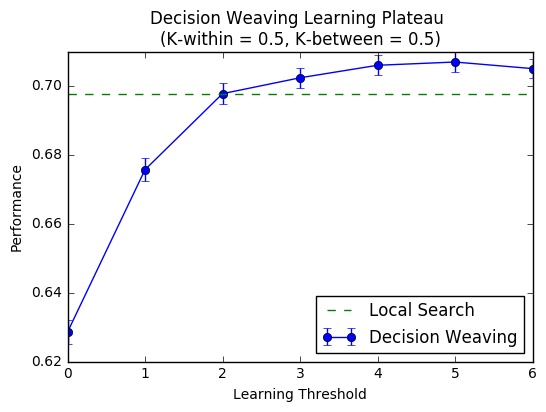

In [84]:
plt.figure()
plt.errorbar(learning_thresholds, thresh_DW_FIT, yerr=thresh_DW_CI, fmt='-o', label='Decision Weaving')
plt.axhline(y=thresh_LOCAL_FIT[0], label='Local Search', ls='dashed', color='g')
plt.xlabel("Learning Threshold")
plt.ylabel("Performance")
plt.title("Decision Weaving Learning Plateau \n(K-within = 0.5, K-between = 0.5)")
plt.legend(loc='best')

## Experiment 3 - Landscape Size

In [17]:
Decisions = [1, 2, 3, 4]

In [21]:
DW_FIT = []
DW_CI = []

LOCAL_FIT = []
LOCAL_CI = []

for d in range(len(Decisions)):
    filename = "NK_landscape_P_3_D_" + str(Decisions[d]) + "_K_within_1.0_K_between_0.5_i_100.npy"
    NK = np.load(filename)
    D = Decisions[d]
    Domain_decision_set = domain_dec_set(D)
    i = NK.shape[0]
    N = int(np.log2(NK.shape[1]))
    P = 3
    Power_key = powerkey(N)

    num_local_steps = []
    num_local_scans = []
    final_local_fitness = []

    num_dw_steps = []
    num_dw_scans = []
    final_dw_fitness = []

    for land in range(i): 
        for _ in range(RUNS):
            start = random_start(N)

            (local_steps, local_scans, local_fit) = local_search(start, N, NK[land], Power_key)
            (dw_steps, dw_scans, dw_fit) = decision_weaving(start, N, P, D, NK[land], Power_key, Domain_decision_set)

            num_local_steps.append(local_steps)
            num_local_scans.append(local_scans)
            final_local_fitness.append(local_fit)

            num_dw_steps.append(dw_steps)
            num_dw_scans.append(dw_scans)
            final_dw_fitness.append(dw_fit)

    DW_FIT.append(np.mean(final_dw_fitness))
    LOCAL_FIT.append(np.mean(final_local_fitness))

    DW_CI.append(conf_int_hw(final_dw_fitness))
    LOCAL_CI.append(conf_int_hw(final_local_fitness))

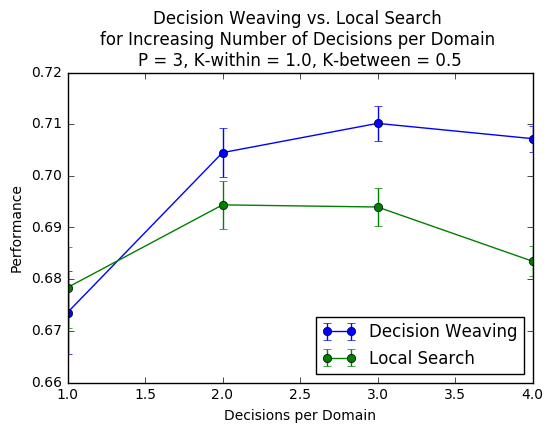

In [22]:
title_str = "Decision Weaving vs. Local Search \nfor Increasing Number of Decisions per Domain \nP = 3, K-within = 1.0, K-between = 0.5"

plt.figure()
plt.errorbar(Decisions, DW_FIT, yerr=DW_CI, fmt='-o', label='Decision Weaving')
plt.errorbar(Decisions, LOCAL_FIT, yerr=LOCAL_CI, fmt='-o', label='Local Search')
plt.xlabel("Decisions per Domain")
plt.ylabel("Performance")
plt.title(title_str)
plt.legend(loc='best')

## Functions

In [10]:
def powerkey(N):
    '''
    Used to find the location on the landscape for a given combination
    of the decision variables. Maps a decision string to the correct row in the NK_land matrix.
    Returns a vector with the powers of two: (2^(N-1), ..., 1)
    '''
    Power_key = np.power(2, np.arange(N - 1, -1, -1))
    return(Power_key)

def calc_fit(N, NK_land, inter_m, Current_position, Power_key):
    '''
    Takes landscape and a combination and returns a vector of fitness
    values (contribution value for each of the N decision variables)
    '''
    Fit_vector = np.zeros(N)
    for ad1 in np.arange(N):
        Fit_vector[ad1] = NK_land[np.sum(Current_position * inter_m[ad1] * Power_key), ad1]
    return(Fit_vector)

def random_start(N):
    return np.random.randint(2, size=N)

def local_search(dec, N, NK, Power_key):
    new_dec = dec.copy()
    new_dec[0] = abs(dec[0] - 1)
    stepped = 0
    scanned = 0

    while(True):
        stepped += 1
        (new_dec, scans) = local_step(N, NK, dec, Power_key)
        scanned += scans
        if (all(new_dec == dec)):
            dec = new_dec
            break
        else:
            dec = new_dec
    return stepped, scanned, NK[np.sum(dec*Power_key), 2*N]

def local_step(N, NK, Current_position, Power_key):
    ''' 
    Local search strategy operates by changing only one decision 
    to reach a better position in the solution space.
    Thus, for a given NK instance and decision set, 
    we randomly iterate through neighbours, and go to the first, better option
    (In keeping with Levinthal, 1997, we don't assume the agent goes to the 
    highest-valued neighbour)
    '''
    scans = 0

    # first make sure we're not at a local peak (if yes, we're done)
    if not local_max(Current_position, N, NK, Power_key):
        Indexes = np.arange(N)
        np.random.shuffle(Indexes)

        Current_fit = fitness(Current_position, N, NK, Power_key)
        New_position = Current_position.copy()

        for new_dec in Indexes:  # check for the neighbourhood
            scans += 1
            New_position[new_dec] = abs(New_position[new_dec] - 1)
            
            if (NK[np.sum(New_position*Power_key), 2*N] > Current_fit):
                # We have found a better position          
                return (New_position, scans)
            # We didn't find a better position => change decision back
            New_position[new_dec] = abs(New_position[new_dec] - 1)

    # If we're here, we must be at a local optimum
    return (Current_position, scans)

def decision_weaving(Current_position, N, P, D, NK, Power_key, Domain_decision_set):
    New_position = Current_position.copy()
    New_position[0] = abs(Current_position[0] - 1)
    unvisited_policies = np.arange(P)
    stepped = 0
    scanned = 0

    np.random.shuffle(unvisited_policies)
    for policy in unvisited_policies:
        (New_position, steps, scans) = search_domain(N, P, D, NK, Current_position, policy, Power_key, Domain_decision_set)
        stepped += steps
        scanned += scans

        Current_position = New_position.copy()

    return stepped, scanned, fitness(Current_position, N, NK, Power_key)

def search_domain(N, P, D, NK, Current_position, policy, Power_key, Domain_decision_set):
    New_position = Current_position.copy()
    random.shuffle(Domain_decision_set)
    steps = 0
    scans = 0

    for pp in Domain_decision_set:
    # check for other decision sets within domain (policy can change)
        if not (all(pp == Current_position[policy*D:(policy+1)*D])):
            scans += 1
            New_position = Current_position.copy()
            New_position[policy*D:(policy+1)*D] = pp

            if (fitness(New_position, N, NK, Power_key) > fitness(Current_position, N, NK, Power_key)):
                # We have found a better position      
                steps += 1
                Current_position = New_position.copy()

            New_position = stepping_stone(N, P, D, NK, Current_position, policy, Power_key)

            if not (all(Current_position == New_position)):
                steps += 1
                Current_position = New_position.copy()
            #if (steps >= 3):
            #    break

    return Current_position, steps, scans

def stepping_stone(N, P, D, NK, Current_position, policy, Power_key):
    Current_fit = fitness(Current_position, N, NK, Power_key)
    New_position = Current_position.copy()

    stepping_stones = np.delete(range(P*D), list(range(policy*D, (policy+1)*D)))
    np.random.shuffle(stepping_stones)
    dec = stepping_stones[0]

    New_position[dec] = abs(New_position[dec] - 1)
            
    if (fitness(New_position, N, NK, Power_key) > Current_fit):
        # We have found a better position          
        return New_position
    else:
        return Current_position

def current_policy(P, D, decision):
    policy = []
    for pp in range(P):
        pol = 0
        for dec in range(D):
            pol += decision[pp*D + dec]
        
        policy.append(int(int(pol) > int(D/2))) # Policy is defined by majority decisions

    return policy

def fitness(position, N, NK, Power_key):
    return NK[np.sum(position*Power_key), 2*N]

def local_max(position, N, NK, Power_key):
    return NK[np.sum(position*Power_key), 2*N+1]

def print_num_steps(steps, indent = "     "):
    print_str = indent + "Average # of steps  = "
    print_str += conf_interval(steps)

    print(print_str)

def print_num_scans(steps, indent = "     "):
    print_str = indent + "Average # of scans  = "
    print_str += conf_interval(steps)

    print(print_str)

def print_fitness(fitness, indent = "     "):
    print_str = indent + "Average fitness     = "
    print_str += conf_interval(fitness)

    print(print_str)

def conf_interval(values, delta=0.05):
    z = st.norm.ppf(1-delta/2)
    point_est = np.mean(values)    
    hw = z * np.sqrt(np.var(values, ddof=1) / len(values))
    c_low = point_est - hw
    c_high = point_est + hw
    return "%.4f with %.f%% Confidence Interval [%.4f" %(point_est, (1-delta)*100, c_low) +  ", %.4f" %c_high + "]"

def conf_int_hw(values, delta=0.05):
    z = st.norm.ppf(1-delta/2)
    point_est = np.mean(values)    
    hw = z * np.sqrt(np.var(values, ddof=1) / len(values))
    #c_low = point_est - hw
    #c_high = point_est + hw
    return hw

def domain_dec_set(D):
    dec_set = []
    for dec in itertools.product(range(2), repeat=D):
        dec_set.append(dec)

    random.shuffle(dec_set)
    return dec_set

In [46]:
def decision_weaving_threshold(Current_position, N, P, D, NK, Power_key, Domain_decision_set, threshold):
    New_position = Current_position.copy()
    New_position[0] = abs(Current_position[0] - 1)
    unvisited_policies = np.arange(P)
    stepped = 0
    scanned = 0

    np.random.shuffle(unvisited_policies)
    for policy in unvisited_policies:
        (New_position, steps, scans) = search_domain_threshold(N, P, D, NK, Current_position, policy, Power_key, Domain_decision_set, threshold)
        stepped += steps
        scanned += scans

        Current_position = New_position.copy()

    return stepped, scanned, fitness(Current_position, N, NK, Power_key)

def search_domain_threshold(N, P, D, NK, Current_position, policy, Power_key, Domain_decision_set, learning_threshold):
    New_position = Current_position.copy()
    random.shuffle(Domain_decision_set)
    steps = 0
    scans = 0

    for pp in Domain_decision_set:
    # check for other decision sets within domain (policy can change)
        if not (all(pp == Current_position[policy*D:(policy+1)*D])):
            scans += 1
            New_position = Current_position.copy()
            New_position[policy*D:(policy+1)*D] = pp

            if (fitness(New_position, N, NK, Power_key) > fitness(Current_position, N, NK, Power_key)):
                # We have found a better position      
                steps += 1
                Current_position = New_position.copy()

            New_position = stepping_stone(N, P, D, NK, Current_position, policy, Power_key)

            if not (all(Current_position == New_position)):
                steps += 1
                Current_position = New_position.copy()
            if (steps >= learning_threshold):
                break

    return Current_position, steps, scans

In [4]:
K_w = [0.0, 0.25, 0.5, 0.75, 1.0]
K_b = [0.0, 0.25, 0.5, 0.75]
len(K_w)

5

In [8]:
import numpy as np
DW_FIT = np.array([[float('nan') for x in range(len(K_w))] for y in range(len(K_b))])
DW_FIT

array([[ nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan]])